In [1]:
device = 'cpu'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import tqdm as tqdm


In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64)),
])

train_dataset = torchvision.datasets.ImageFolder('celeb-hq/data/celeba_hq/train', transform=transforms)
# test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
print(train_dataset.classes)


Training with 28000 samples
['female', 'male']


tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000])


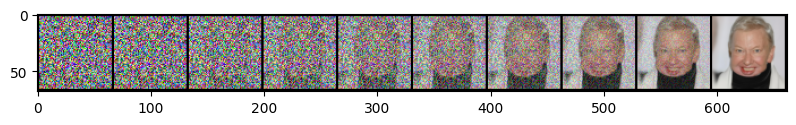

In [4]:
@torch.no_grad()
def noiser(img, noise, t):
    noise_scale = torch.as_tensor(torch.cos((t) * (3.1415/2)), device=device).view(-1, 1, 1, 1)
    return img * (1-noise_scale) + noise * (noise_scale)


x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

t = torch.arange(1, 11, device=device) / 10
print(t)
noise = torch.rand_like(x[0])
noised = noiser(x[0], noise, t)
grid = torchvision.utils.make_grid(noised, nrow=10)
plt.figure(figsize=(10, 1))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()


In [20]:
class DPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Conv2d(5, 32, 3, padding=1, stride=2)
        self.attention1 = nn.MultiheadAttention(embed_dim=1024, num_heads=2)
        
        self.down2 = nn.Conv2d(32+2, 64, 3, padding=1, stride=2)
        self.attention2 = nn.MultiheadAttention(embed_dim=256, num_heads=2)
        
        self.down3 = nn.Conv2d(64+2, 128, 3, padding=1, stride=2)
        self.attention3 = nn.MultiheadAttention(embed_dim=64, num_heads=2)

        self.up1 = nn.ConvTranspose2d(128+2, 64, 3, padding=1, stride=2, output_padding=1)
        self.attention4 = nn.MultiheadAttention(embed_dim=256, num_heads=2)
        
        self.up2 = nn.ConvTranspose2d(64+2, 32, 3, padding=1, stride=2, output_padding=1)
        self.attention5 = nn.MultiheadAttention(embed_dim=1024, num_heads=2)
        
        self.up3 = nn.ConvTranspose2d(32+2, 32, 3, padding=1, stride=2, output_padding=1)

        self.out = nn.Conv2d(32, 3, 3, padding=1)

        self.time_embeds = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 64 * 64),
        )

        self.class_embeds = nn.Embedding(2, 64 * 64)

    def forward(self, x, y, t):
        t_emb = self.time_embeds(t.view(-1, 1))
        t_emb = t_emb.view(-1, 1, 64, 64)
        y_emb = self.class_embeds(y.view(-1))
        y_emb = y_emb.view(-1, 1, 64, 64)

        x = torch.cat([x, t_emb, y_emb], dim=1)
        
        x1 = F.silu(self.down1(x))
        x1 = torch.cat([x1, F.max_pool2d(t_emb, 2), F.max_pool2d(y_emb, 2)], dim=1)
        b, c, h, w = x1.shape
        x1 = x1.view(c, b, h*w)
        x1, _ = self.attention1(x1, x1, x1)
        x1 = x1.view(b, c, h, w)
        
        x2 = F.silu(self.down2(x1))
        x2 = torch.cat([x2, F.max_pool2d(t_emb, 4), F.max_pool2d(y_emb, 4)], dim=1)
        b, c, h, w = x2.shape
        x2 = x2.view(c, b, h*w)
        x2, _ = self.attention2(x2, x2, x2)
        x2 = x2.view(b, c, h, w)
        
        x3 = F.silu(self.down3(x2))
        x3 = torch.cat([x3, F.max_pool2d(t_emb, 8), F.max_pool2d(y_emb, 8)], dim=1)
        b, c, h, w = x3.shape
        x3 = x3.view(c, b, h*w)
        x3, _ = self.attention3(x3, x3, x3)
        x3 = x3.view(b, c, h, w)

        x4 = F.silu(self.up1(x3))
        x4 = torch.cat([x4, F.max_pool2d(t_emb, 4), F.max_pool2d(y_emb, 4)], dim=1)
        b, c, h, w = x4.shape
        x4 = x4.view(c, b, h*w)
        x4, _ = self.attention4(x4, x4, x4)
        x4 = x4.view(b, c, h, w)
        
        
        
        x5 = F.silu(self.up2(x4))
        x5 = torch.cat([x5, F.max_pool2d(t_emb, 2), F.max_pool2d(y_emb, 2)], dim=1)
        b, c, h, w = x5.shape
        x5 = x5.view(c, b, h*w)
        x5, _ = self.attention5(x5, x5, x5)
        x5 = x5.view(b, c, h, w)
        
        
        
        x6 = F.silu(self.up3(x5))

        x7 = self.out(x6)
        return x7


model = DPM().to(device)
criterion = F.mse_loss

print(
    f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters"
)
print(
    f"Model is using {sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024:.2f} MB of memory"
)


Model has 9,286,211 parameters
Model is using 35.42 MB of memory


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
total_steps = 10


  0%|          | 0/875 [00:00<?, ?it/s]

Epoch 0:   0%|          | 1/875 [00:03<44:13,  3.04s/it, Loss: 0.26472917199134827]

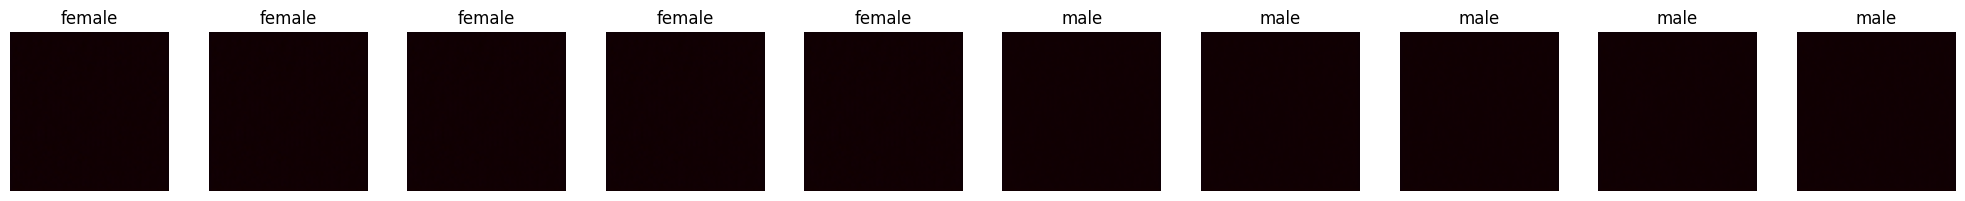

Epoch 0:  12%|█▏        | 101/875 [01:48<13:43,  1.06s/it, Loss: 0.061511099338531494]

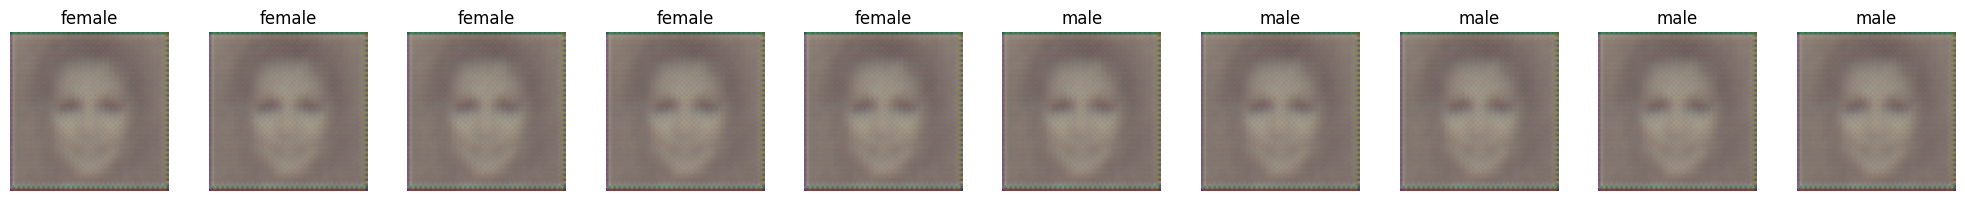

Epoch 0:  23%|██▎       | 201/875 [03:32<11:27,  1.02s/it, Loss: 0.05496232584118843] 

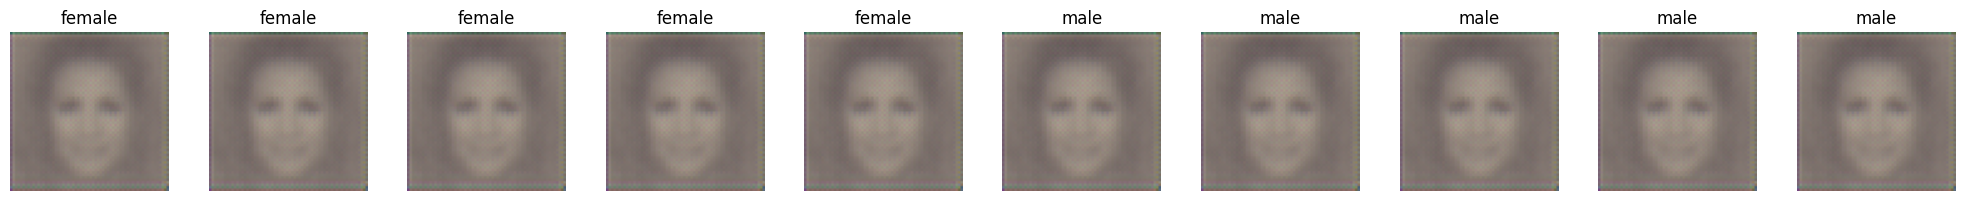

Epoch 0:  34%|███▍      | 301/875 [05:15<09:03,  1.06it/s, Loss: 0.05779742822051048] 

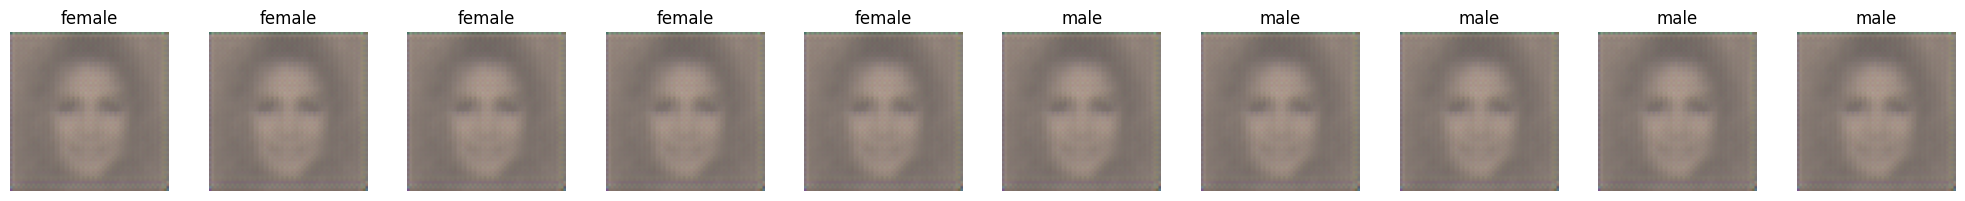

Epoch 0:  46%|████▌     | 401/875 [06:55<08:16,  1.05s/it, Loss: 0.0598638541996479]  

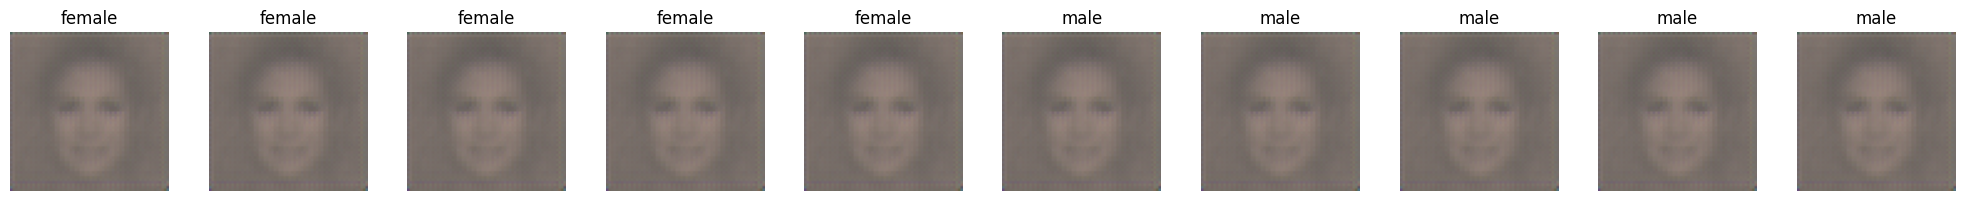

Epoch 0:  54%|█████▍    | 472/875 [08:14<07:02,  1.05s/it, Loss: 0.0653565526008606]


KeyboardInterrupt: 

In [22]:
for epoch in range(10):
    with tqdm.tqdm(train_loader) as pbar:
        for x, y in tqdm.tqdm(train_loader):
            model.train()
            x = x.to(device)
            y = y.to(device)
            
            t = torch.randint(0, total_steps, (x.shape[0],), device=device, dtype=torch.float32) / total_steps
            noise = torch.rand_like(x, device=device)
            noisy_x = noiser(x, noise, t)
            target_x = noiser(x, noise, t + (1 / total_steps))
            
            optimizer.zero_grad()
            output = model(noisy_x, y, t)
            loss = criterion(output, target_x)
            loss.backward()
            optimizer.step()
            
            pbar.update()
            pbar.set_postfix_str(f"Loss: {loss.item()}", refresh=True if pbar.n % 50 == 0 else False)
            pbar.set_description(f"Epoch {epoch}")
            
            if pbar.n % 100 == 1:
                with torch.no_grad():
                    # Generate a grid of random images
                    model.eval()
                    noise = torch.rand((10, 3, 64, 64), device=device)
                    y = torch.cat([torch.zeros(5, device=device), torch.ones(5, device=device)]).long()

                    for i in range(total_steps):
                        t = torch.tensor([10 * [i]], device=device, dtype=torch.float32) / total_steps
                        noise = model(noise, y, t)
                        
                    y = y.flatten().long().tolist()
                    plt.figure(figsize=(20, 2))
                    for i in range(10):
                        plt.subplot(1, 10, i + 1)
                        plt.imshow(noise[i].detach().cpu().permute(1, 2, 0).clamp(0, 1))
                        plt.axis('off')
                        plt.title("female" if y[i] == 0 else "male")
                        
                    plt.tight_layout()
                    plt.show()


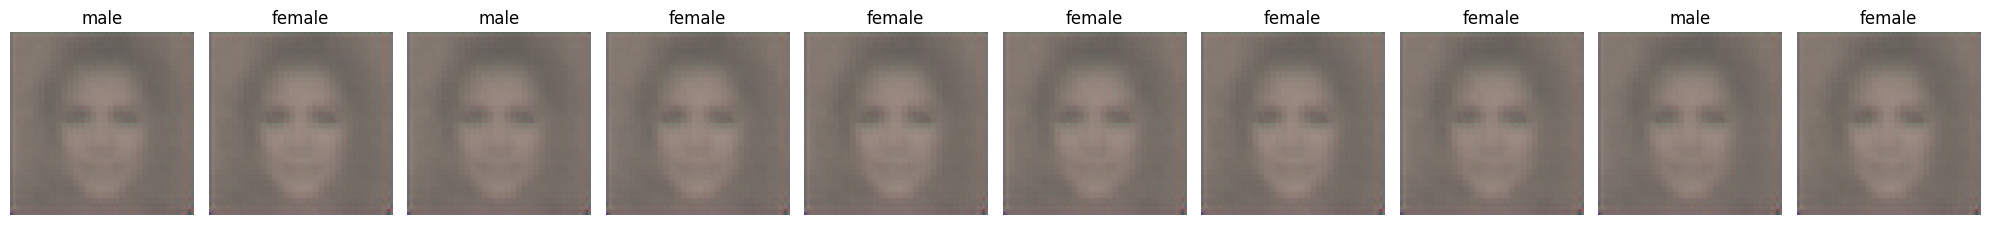

In [13]:
with torch.no_grad():
    # Generate a grid of random images
    model.eval()
    noise = torch.rand((10, 3, 64, 64), device=device)
    y = torch.randint(0, 2, (10,), device=device)

    for i in range(total_steps):
        t = torch.tensor([10 * [i / total_steps]], device=device, dtype=torch.float32)
        noise = model(noise, y, t)
                        
    y = y.flatten().long().tolist()
    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(noise[i].detach().cpu().permute(1, 2, 0).clamp(0, 1))
        plt.axis('off')
        plt.title("female" if y[i] == 0 else "male")
                        
    plt.tight_layout()
    plt.show()


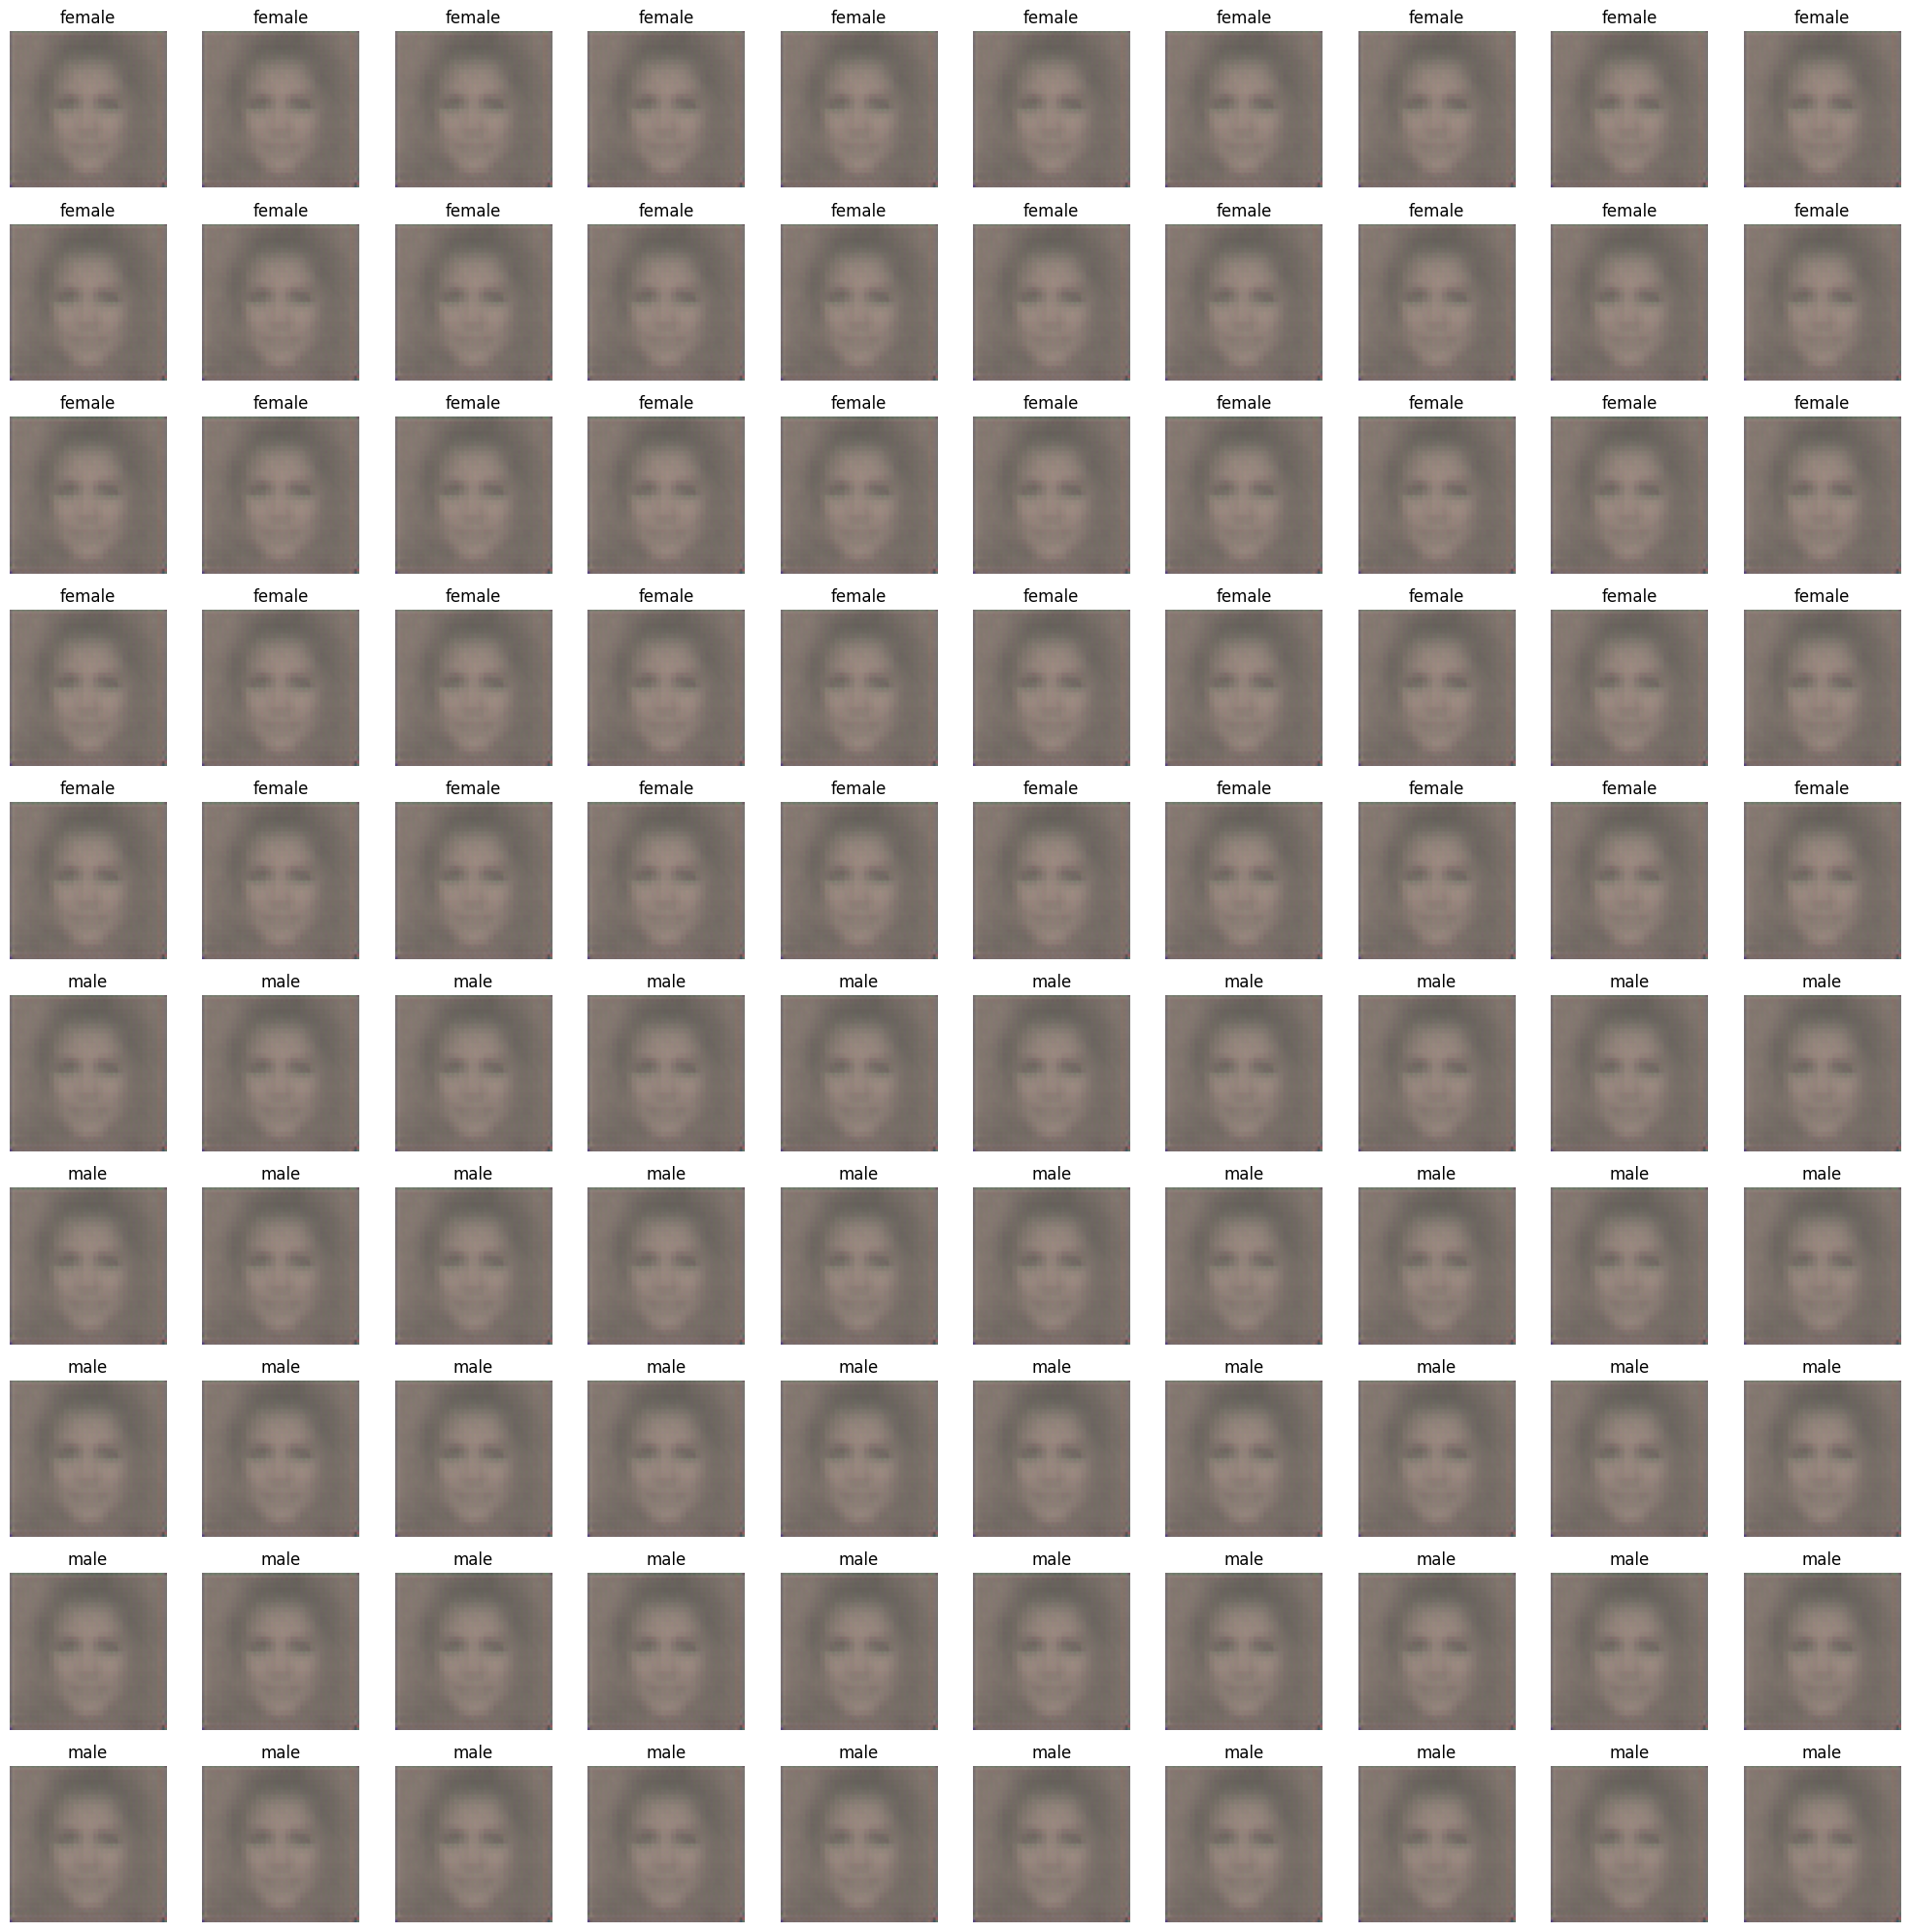

In [15]:
with torch.no_grad():
    # Generate a grid of random images
    model.eval()
    noise = torch.rand((100, 3, 64, 64), device=device)
    y = torch.cat([torch.zeros(50, device=device), torch.ones(50, device=device)]).long()

    for i in range(total_steps):
        t = torch.tensor([100 * [i / total_steps]], device=device, dtype=torch.float32)
        noise = model(noise, y, t)
        
    y = y.flatten().long().tolist()
    plt.figure(figsize=(20, 20))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(noise[i].detach().cpu().permute(1, 2, 0).clamp(0, 1))
        plt.axis('off')
        plt.title("female" if y[i] == 0 else "male")
        
    plt.tight_layout()
    plt.show()
